In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
predict_students_dropout_and_academic_success = fetch_ucirepo(id=697) 
  
# data (as pandas dataframes) 
X = predict_students_dropout_and_academic_success.data.features 
y = predict_students_dropout_and_academic_success.data.targets 
  
# metadata 
print(predict_students_dropout_and_academic_success.metadata) 
  
# variable information 
print(predict_students_dropout_and_academic_success.variables) 

{'uci_id': 697, 'name': "Predict Students' Dropout and Academic Success", 'repository_url': 'https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success', 'data_url': 'https://archive.ics.uci.edu/static/public/697/data.csv', 'abstract': "A dataset created from a higher education institution (acquired from several disjoint databases) related to students enrolled in different undergraduate degrees, such as agronomy, design, education, nursing, journalism, management, social service, and technologies.\nThe dataset includes information known at the time of student enrollment (academic path, demographics, and social-economic factors) and the students' academic performance at the end of the first and second semesters. \nThe data is used to build classification models to predict students' dropout and academic sucess. The problem is formulated as a three category classification task, in which there is a strong imbalance towards one of the classes.", 'area': 'Social Sc

# Train


In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo

In [4]:
dataset = fetch_ucirepo(id=697)
X = dataset.data.features.values.astype(np.float32)
y = dataset.data.targets.values.ravel()

# Encode string labels to integers
le = LabelEncoder()
y = le.fit_transform(y)
num_classes = len(np.unique(y))
print("Class mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

Class mapping: {'Dropout': np.int64(0), 'Enrolled': np.int64(1), 'Graduate': np.int64(2)}


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

In [6]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_val   = scaler.transform(X_val).astype(np.float32)
X_test  = scaler.transform(X_test).astype(np.float32)

In [7]:
train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train).long())
val_ds   = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val).long())
test_ds  = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test).long())

batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [8]:
class EfficientMLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientMLP(X_train.shape[1], num_classes).to(device)


In [9]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)

# Optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

In [10]:
epochs = 50
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

best_val_loss = float('inf')
patience = 7
trigger_times = 0

def evaluate(loader):
    model.eval()
    total_loss, total_correct, total_count = 0.0, 0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            total_loss += loss.item() * xb.size(0)
            preds = logits.argmax(dim=1)
            total_correct += (preds == yb).sum().item()
            total_count += xb.size(0)
    return total_loss / total_count, total_correct / total_count

for epoch in range(1, epochs+1):
    model.train()
    running_loss, running_correct, running_count = 0.0, 0, 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
        preds = logits.argmax(dim=1)
        running_correct += (preds == yb).sum().item()
        running_count += xb.size(0)

    train_epoch_loss = running_loss / running_count
    train_epoch_acc  = running_correct / running_count
    val_epoch_loss, val_epoch_acc = evaluate(val_loader)

    scheduler.step(val_epoch_loss)

    history['train_loss'].append(train_epoch_loss)
    history['val_loss'].append(val_epoch_loss)
    history['train_acc'].append(train_epoch_acc)
    history['val_acc'].append(val_epoch_acc)

    print(f"Epoch {epoch:02d}/{epochs} | "
          f"train_loss={train_epoch_loss:.4f} val_loss={val_epoch_loss:.4f} "
          f"train_acc={train_epoch_acc:.4f} val_acc={val_epoch_acc:.4f}")

    # Early stopping
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping triggered!")
            break


Epoch 01/50 | train_loss=0.9163 val_loss=0.7457 train_acc=0.6104 val_acc=0.7232
Epoch 02/50 | train_loss=0.7854 val_loss=0.7183 train_acc=0.6955 val_acc=0.7274
Epoch 03/50 | train_loss=0.7463 val_loss=0.7106 train_acc=0.7054 val_acc=0.7246
Epoch 04/50 | train_loss=0.7038 val_loss=0.6947 train_acc=0.7266 val_acc=0.7288
Epoch 05/50 | train_loss=0.6882 val_loss=0.6922 train_acc=0.7365 val_acc=0.7387
Epoch 06/50 | train_loss=0.6777 val_loss=0.6852 train_acc=0.7450 val_acc=0.7316
Epoch 07/50 | train_loss=0.6652 val_loss=0.6973 train_acc=0.7520 val_acc=0.7203
Epoch 08/50 | train_loss=0.6657 val_loss=0.6790 train_acc=0.7315 val_acc=0.7359
Epoch 09/50 | train_loss=0.6416 val_loss=0.6877 train_acc=0.7527 val_acc=0.7345
Epoch 10/50 | train_loss=0.6511 val_loss=0.6898 train_acc=0.7436 val_acc=0.7429
Epoch 11/50 | train_loss=0.6605 val_loss=0.6766 train_acc=0.7517 val_acc=0.7274
Epoch 12/50 | train_loss=0.6426 val_loss=0.6801 train_acc=0.7566 val_acc=0.7189
Epoch 13/50 | train_loss=0.6319 val_loss

In [11]:
model.eval()
all_preds, all_true = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_true.extend(yb.numpy())

print("\nClassification Report:")
print(classification_report(all_true, all_preds, target_names=le.classes_))


Classification Report:
              precision    recall  f1-score   support

     Dropout       0.79      0.70      0.74       284
    Enrolled       0.40      0.60      0.48       159
    Graduate       0.86      0.77      0.81       442

    accuracy                           0.72       885
   macro avg       0.68      0.69      0.68       885
weighted avg       0.76      0.72      0.73       885



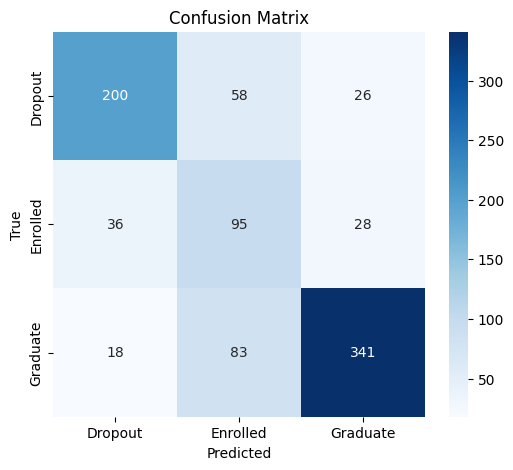

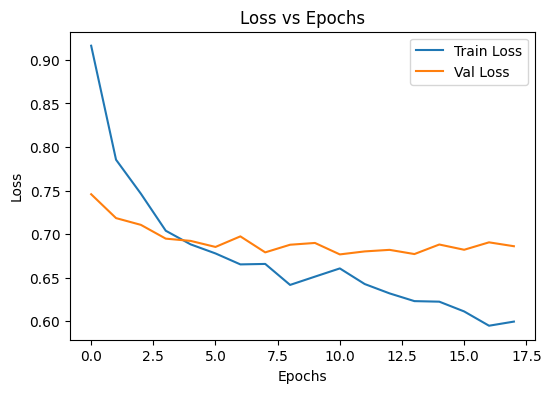

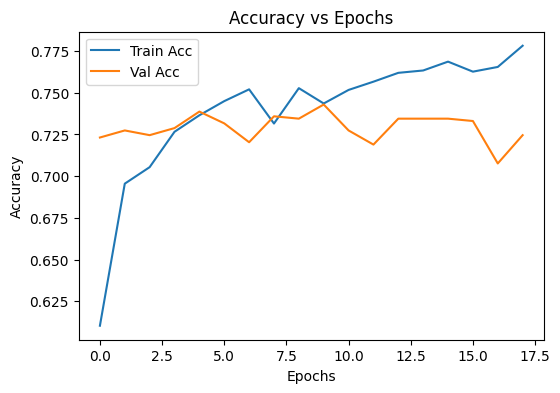

In [12]:
cm = confusion_matrix(all_true, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Learning Curves
plt.figure(figsize=(6,4))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss vs Epochs')
plt.show()

plt.figure(figsize=(6,4))
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend(); plt.title('Accuracy vs Epochs')
plt.show()

/var/folders/tq/h_vw_lvn17g5f24p0db38fww0000gn/T/ipykernel_26119/1475153585.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette="viridis")


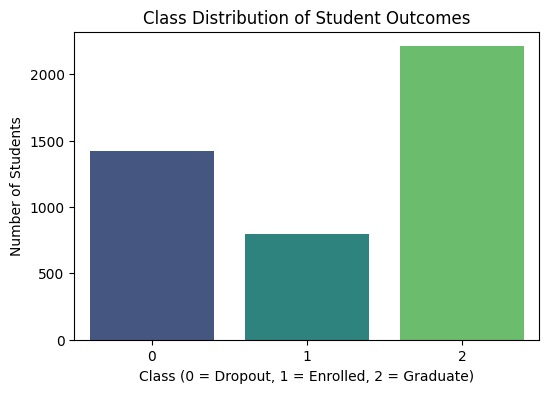

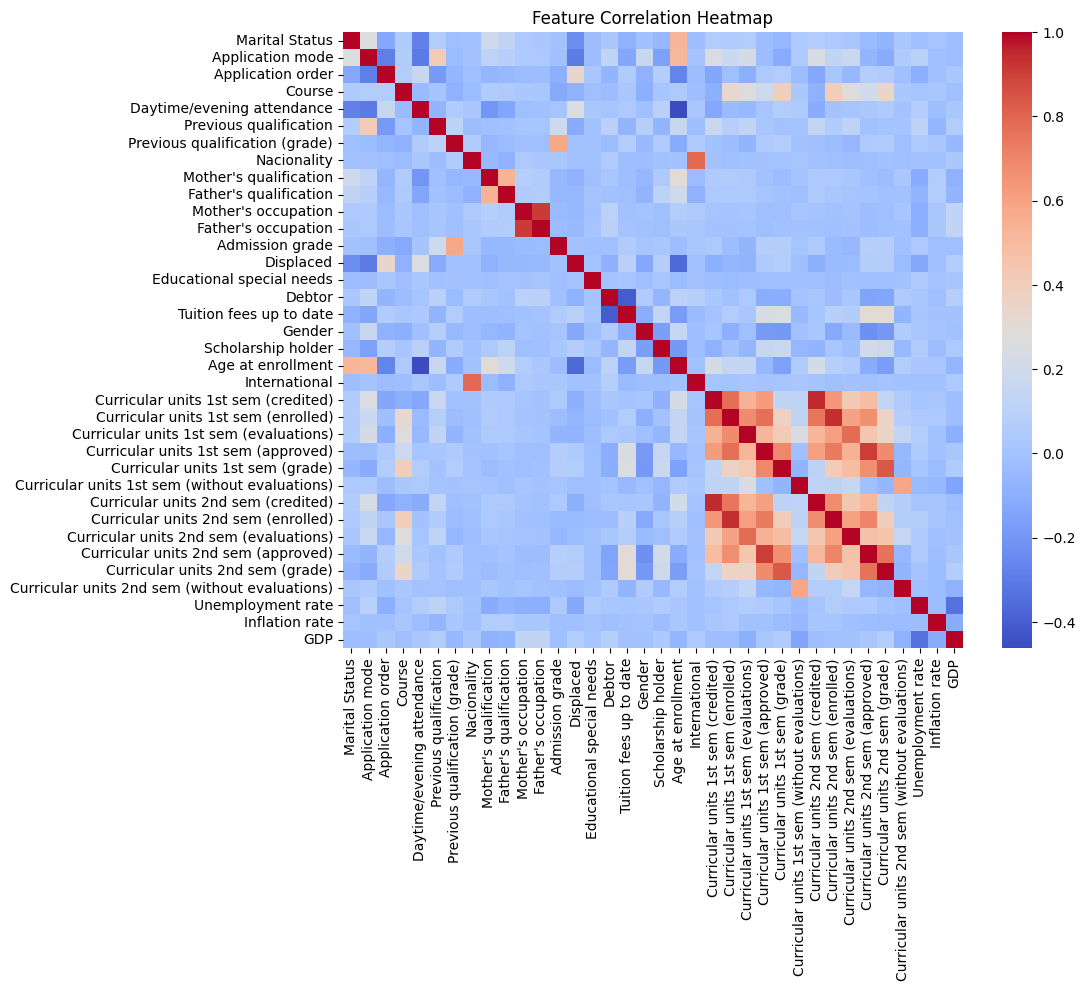

In [14]:


import seaborn as sns

# Plot class distribution
plt.figure(figsize=(6,4))
sns.countplot(x=y, palette="viridis")
plt.title("Class Distribution of Student Outcomes")
plt.xlabel("Class (0 = Dropout, 1 = Enrolled, 2 = Graduate)")
plt.ylabel("Number of Students")
plt.show()

# Use original DataFrame (not the NumPy array) for correlations
plt.figure(figsize=(10,8))
corr = predict_students_dropout_and_academic_success.data.features.corr()
sns.heatmap(corr, cmap="coolwarm", annot=False, cbar=True)
plt.title("Feature Correlation Heatmap")
plt.show()


In [15]:
# --- Commit 2: Add learning rate scheduler and track learning rates ---

from torch.optim.lr_scheduler import StepLR

# Define scheduler (decay LR by 0.5 every 5 epochs)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

# Update training loop with scheduler
for epoch in range(1, epochs+1):
    model.train()
    running_loss, running_correct, running_count = 0.0, 0, 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * xb.size(0)
        preds = logits.argmax(dim=1)
        running_correct += (preds == yb).sum().item()
        running_count += xb.size(0)

    # Step scheduler
    scheduler.step()

    # Track learning rate
    current_lr = scheduler.get_last_lr()[0]

    train_epoch_loss = running_loss / running_count
    train_epoch_acc  = running_correct / running_count
    val_epoch_loss, val_epoch_acc = evaluate(val_loader)

    history['train_loss'].append(train_epoch_loss)
    history['val_loss'].append(val_epoch_loss)
    history['train_acc'].append(train_epoch_acc)
    history['val_acc'].append(val_epoch_acc)

    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:02d}/{epochs} | "
              f"train_loss={train_epoch_loss:.4f} val_loss={val_epoch_loss:.4f} "
              f"train_acc={train_epoch_acc:.4f} val_acc={val_epoch_acc:.4f} "
              f"lr={current_lr:.6f}")


Epoch 01/50 | train_loss=0.6116 val_loss=0.6829 train_acc=0.7644 val_acc=0.7288 lr=0.000500
Epoch 05/50 | train_loss=0.5831 val_loss=0.6882 train_acc=0.7753 val_acc=0.7218 lr=0.000250
Epoch 10/50 | train_loss=0.5610 val_loss=0.6901 train_acc=0.7859 val_acc=0.7246 lr=0.000125
Epoch 15/50 | train_loss=0.5633 val_loss=0.6919 train_acc=0.7842 val_acc=0.7232 lr=0.000063
Epoch 20/50 | train_loss=0.5784 val_loss=0.6976 train_acc=0.7803 val_acc=0.7218 lr=0.000031
Epoch 25/50 | train_loss=0.5607 val_loss=0.6946 train_acc=0.7881 val_acc=0.7274 lr=0.000016
Epoch 30/50 | train_loss=0.5496 val_loss=0.6888 train_acc=0.7856 val_acc=0.7218 lr=0.000008
Epoch 35/50 | train_loss=0.5511 val_loss=0.6917 train_acc=0.7909 val_acc=0.7175 lr=0.000004
Epoch 40/50 | train_loss=0.5628 val_loss=0.6922 train_acc=0.7881 val_acc=0.7316 lr=0.000002
Epoch 45/50 | train_loss=0.5768 val_loss=0.6976 train_acc=0.7729 val_acc=0.7415 lr=0.000001
Epoch 50/50 | train_loss=0.5526 val_loss=0.6921 train_acc=0.7927 val_acc=0.7274 